In [2]:
import numpy as np
import xarray as xr 
import pandas as pd
import glob
import os

import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, detrend

from matplotlib.ticker import LogLocator, FuncFormatter

import sys
sys.path.append('..//')
from utils_mitgcm import open_mitgcm_ds_from_config
from utils_signal_processing import *
from utils_energy_analysis import *

from datetime import datetime

# Load data and select ZZ
- selected zz and sliced through time

In [3]:
output_folder = r"/home/leroquan@eawag.wroot.emp-eaw.ch/work_space/dummy_extended/seiche_analysis/"

In [4]:
model = 'geneva_dummy_extended'
mitgcm_config, ds = open_mitgcm_ds_from_config('..//config.json', model)

In [5]:
grid_resolution = 200
ds['YC'] = np.arange(1, len(ds['YC'])+1) * grid_resolution - grid_resolution/2
ds['XC'] = np.arange(1, len(ds['XC'])+1) * grid_resolution - grid_resolution/2
ds['YG'] = np.arange(0, len(ds['YG'])) * grid_resolution
ds['XG'] = np.arange(0, len(ds['XG'])) * grid_resolution

In [5]:
zz = 0

In [5]:
u = ds.UVEL.sel(Z=zz,method='nearest')
v = ds.VVEL.sel(Z=zz,method='nearest')
w = ds.WVEL.sel(Zl=zz,method='nearest')

In [ ]:
u.load()
v.load()
w.load()

# Compute freq. spectrum

## Compute freq. spectrum

In [7]:
m_seg = 1
u_fft = xr_compute_meanfft(u, M=m_seg)
v_fft = xr_compute_meanfft(v, M=m_seg)
w_fft = xr_compute_meanfft(w, M=m_seg)

/home/leroquan@eawag.wroot.emp-eaw.ch/horizontal_structure_analysis/utils_signal_processing/fast_fourier_transform.py:42: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  amp_mean, err_up, err_low = xr.apply_ufunc(

KeyboardInterrupt



## Select sub XY for mean freq. Spectrum

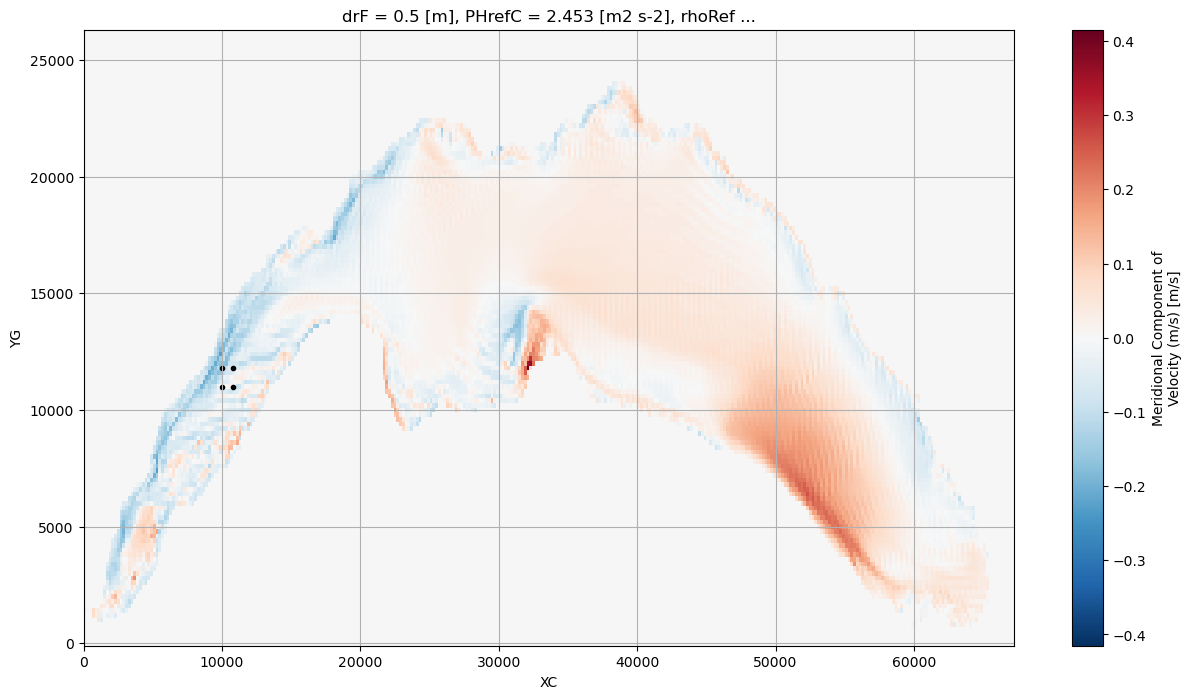

In [12]:
xx1 = 10000
yy1 = 11000
xcells = 4
ycells = 4
xx2 = xx1+(200*xcells)
yy2 = yy1+(200*ycells)

fig, ax = plt.subplots(1, figsize=(15, 8))
v.isel(time=24).plot()
plt.scatter(xx1,yy1, marker=".", color="k")
plt.scatter(xx1,yy2, marker = '.', color="k")
plt.scatter(xx2,yy1, marker=".", color="k")
plt.scatter(xx2,yy2, marker = '.', color="k")

plt.grid()

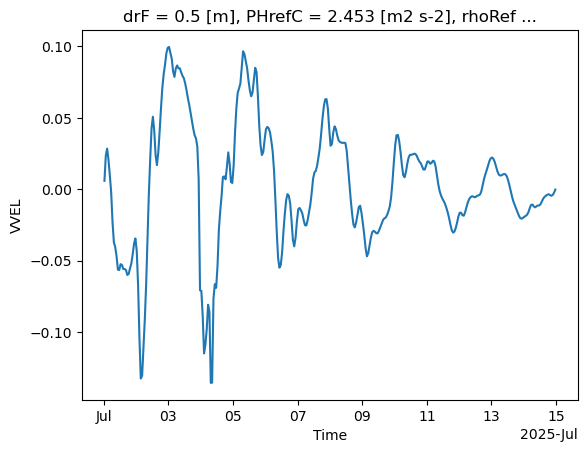

In [13]:
v.sel(XC=slice(xx1,xx2), YG=slice(yy1,yy2)).mean(dim=['XC','YG']).plot()

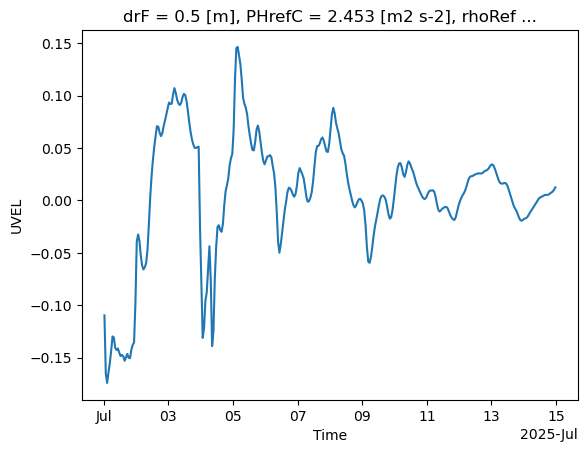

In [14]:
u.sel(XG=slice(xx1,xx2), YC=slice(yy1,yy2)).mean(dim=['XG','YC']).plot()

In [15]:
u_fft_mean = u_fft.sel(XG=slice(xx1,xx2), YC=slice(yy1,yy2)).mean(dim=['XG','YC'])
v_fft_mean = v_fft.sel(XC=slice(xx1,xx2), YG=slice(yy1,yy2)).mean(dim=['XC','YG'])
w_fft_mean = w_fft.sel(XC=slice(xx1,xx2), YC=slice(yy1,yy2)).mean(dim=['XC','YC'])

## Plot freq. spectrum

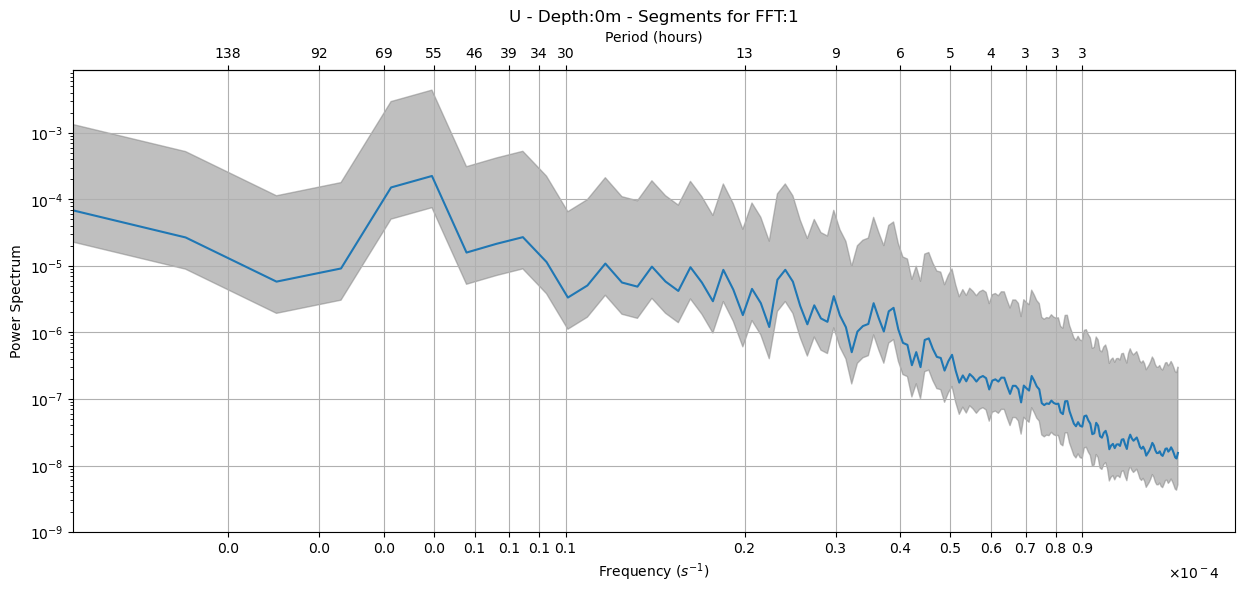

In [16]:
fig,ax = plot_freq_spectrum(u_fft_mean, 'U', depth=zz, m_segm=m_seg, y_lim_min=1e-9, x_lim_min=0.01e-4, fontsize=10)
fig.savefig(os.path.join(output_folder, 'freq_spectrum.png'))

# Filtering in Spectral space  

## Defining cutoffs 
- Inertial period is at 16.4 hrs

In [14]:
cutoff1_hr = 90
cutoff2_hr = 46

cutoff1 = 1/(cutoff1_hr * 3600)
cutoff2 = 1/(cutoff2_hr * 3600)

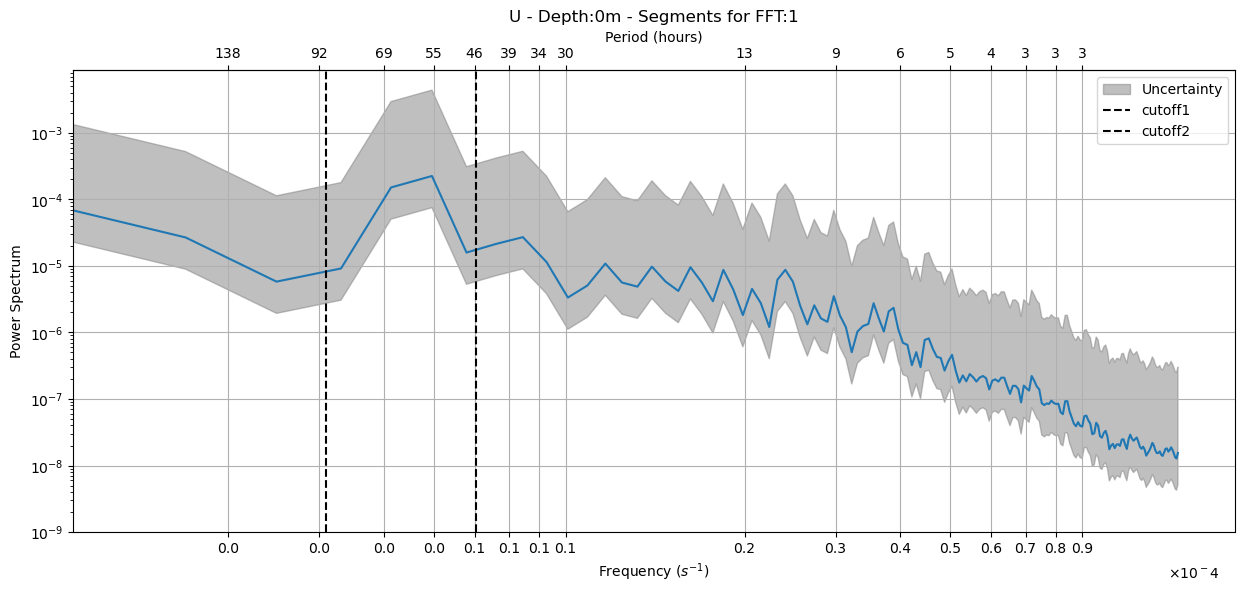

In [70]:
fig,ax = plot_freq_spectrum(u_fft_mean, 'U', depth=zz, m_segm=m_seg, y_lim_min=1e-9, x_lim_min=0.01e-4, fontsize=10)
ax.axvline(x = cutoff1, linestyle="--", color="k",label="cutoff1")
ax.axvline(x = cutoff2, linestyle="--", color="k",label="cutoff2")
ax.legend()
fig.savefig(os.path.join(output_folder, f'freq_spectrum_with_cutoffs_{cutoff2_hr}_{cutoff1_hr}h.png'))

In [15]:
path_cutoff_folder = os.path.join(output_folder, f'{cutoff2_hr}_{cutoff1_hr}h')
os.makedirs(path_cutoff_folder, exist_ok=True)

## Low-pass filtering (slow motions)

### Filtering to low freq. motions

In [ ]:
ulow = filter_signal_xarray(u, btype='lowpass', time_dim='time', dt=3600, period_cutoff_high=(cutoff1_hr*3600), order=5)
vlow = filter_signal_xarray(v, btype='lowpass', time_dim='time', dt=3600, period_cutoff_high=(cutoff1_hr*3600), order=5)
wlow = filter_signal_xarray(w, btype='lowpass', time_dim='time', dt=3600, period_cutoff_high=(cutoff1_hr*3600), order=5)

### Plotting low freq. motions 

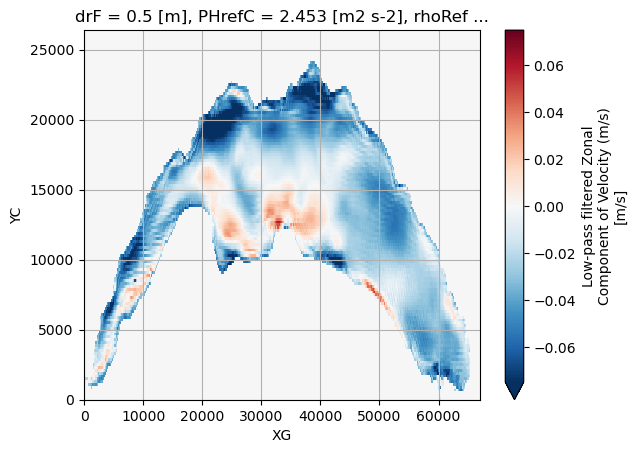

In [37]:
i_time_to_plot = 30

vmax_low = 7.5e-2
ulow.isel(time=i_time_to_plot).plot(vmax=vmax_low)
plt.grid()

## Bandpass filtering (seiches)

### Filtering to seiches

In [38]:
useiche = filter_signal_xarray(u, btype='bandpass', time_dim='time', dt=3600, period_cutoff_low=(cutoff1_hr*3600), period_cutoff_high=(cutoff2_hr*3600), order=5)
vseiche = filter_signal_xarray(v, btype='bandpass', time_dim='time', dt=3600, period_cutoff_low=(cutoff1_hr*3600), period_cutoff_high=(cutoff2_hr*3600), order=5)
wseiche = filter_signal_xarray(w, btype='bandpass', time_dim='time', dt=3600, period_cutoff_low=(cutoff1_hr*3600), period_cutoff_high=(cutoff2_hr*3600), order=5)

### Plotting seiches 

25


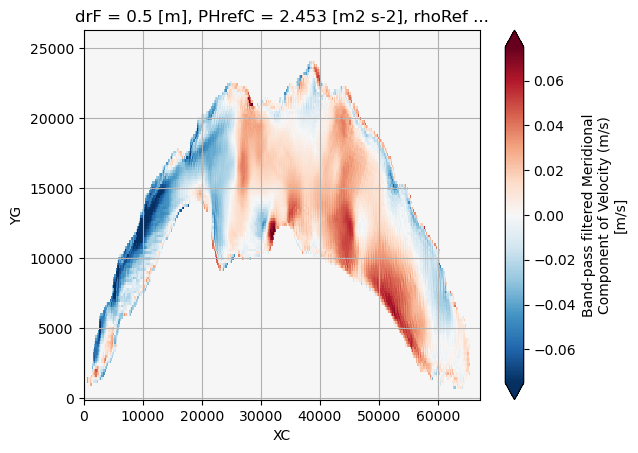

In [39]:
i_time_to_plot += 1
print(i_time_to_plot)
vmax_seiche = 7.5e-2
vseiche.isel(time=i_time_to_plot).plot(vmax=vmax_seiche)
plt.grid()

## High-pass filtering (high frq. waves)

### Filtering to high freq. waves 

In [40]:
uhigh = filter_signal_xarray(u, btype='highpass', time_dim='time', dt=3600, period_cutoff_low=(cutoff2_hr*3600), order=5)
vhigh = filter_signal_xarray(v, btype='highpass', time_dim='time', dt=3600, period_cutoff_low=(cutoff2_hr*3600), order=5)
whigh = filter_signal_xarray(w, btype='highpass', time_dim='time', dt=3600, period_cutoff_low=(cutoff2_hr*3600), order=5)


### Plot high freq. internal waves

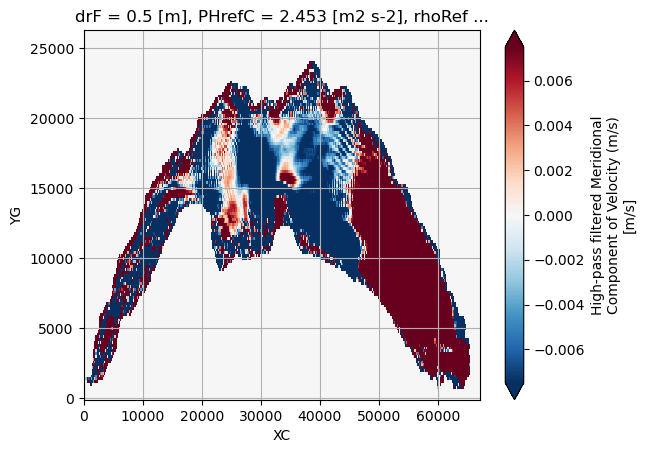

In [41]:
vmax_high = 7.5e-3
vhigh.isel(time=i_time_to_plot).plot(vmax=vmax_high)
plt.grid()

## Comparing time series

In [43]:
def plot_comparison_timeseries(xx, yy, vel, low, seiche, high, name_var, x_name="XG", y_name="YC"):
    fig, ax = plt.subplots(2, 1, figsize=(18, 8))

    # upper plot
    low.sel({x_name: xx, y_name: yy}, method="nearest").plot(ax=ax[0], label="low freq.")
    seiche.sel({x_name: xx, y_name: yy}, method="nearest").plot(ax=ax[0], label="seiche")
    high.sel({x_name: xx, y_name: yy}, method="nearest").plot(ax=ax[0], label="high freq.")

    # bottom plot
    vel.sel({x_name: xx, y_name: yy}, method="nearest").plot(ax=ax[1], label="Original")
    (low + seiche + high).sel({x_name: xx, y_name: yy}, method="nearest").plot( ax=ax[1], label="low freq + seiche + high freq")

    for ax_i in (ax[0], ax[1]):
        ax_i.grid()
        ax_i.set_xlabel('')
        ax_i.legend(loc='upper right')
        ax_i.set_ylabel(f'{name_var} (m/s)')


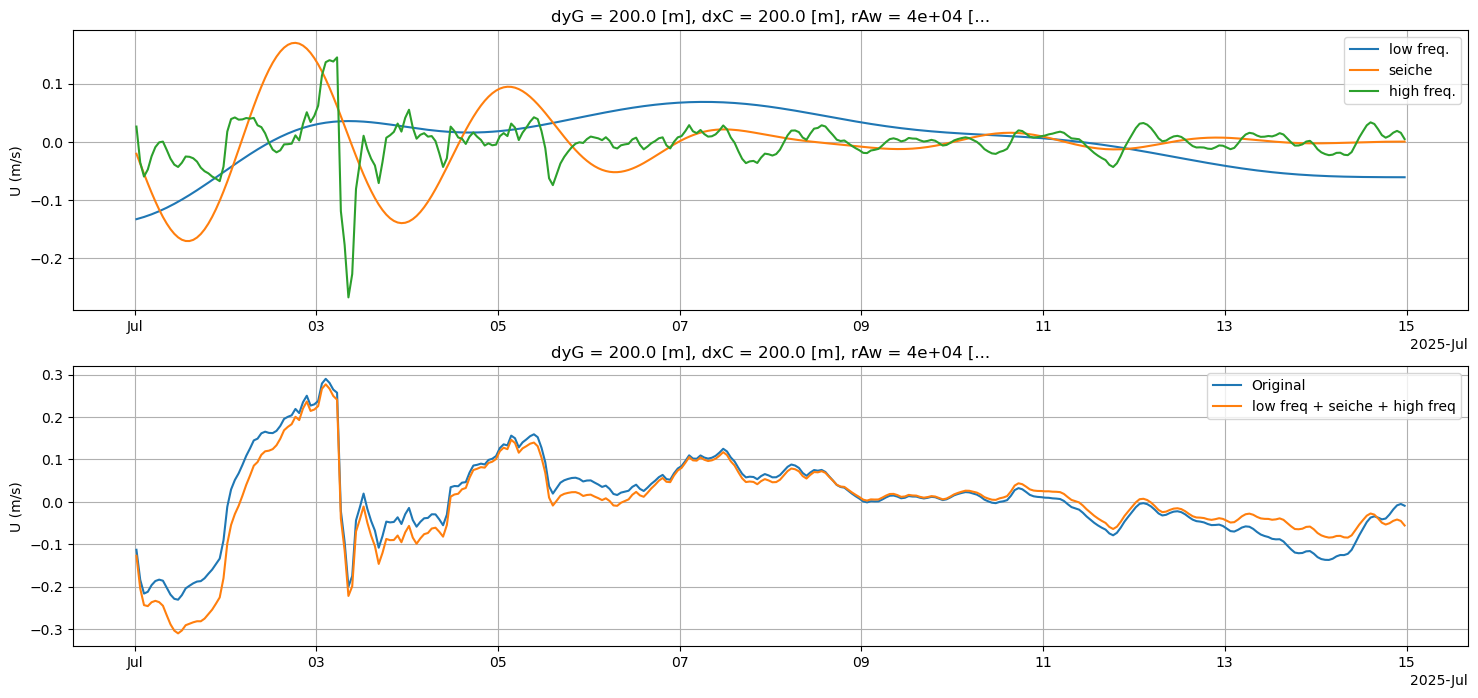

In [67]:
xx = 40000; yy = 20000
plot_comparison_timeseries(xx, yy, u, ulow, useiche, uhigh, 'U', x_name="XG", y_name="YC")
plt.savefig(os.path.join(path_cutoff_folder, f'plot_filtered_timeseries_{cutoff2_hr}-{cutoff1_hr}h_U.png'))

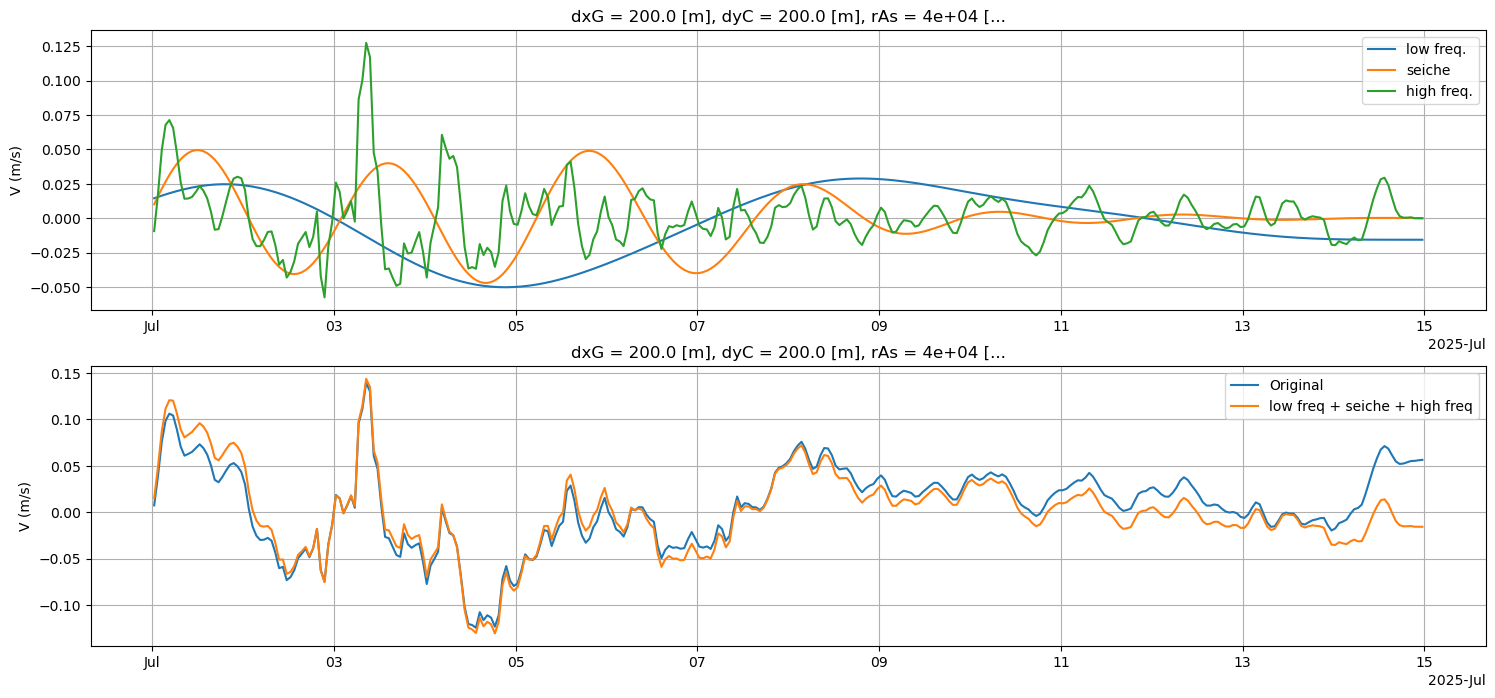

In [68]:
plot_comparison_timeseries(xx, yy, v, vlow, vseiche, vhigh, 'V', x_name="XC", y_name="YG")
plt.savefig(os.path.join(path_cutoff_folder, f'plot_filtered_timeseries_{cutoff2_hr}-{cutoff1_hr}h_V.png'))

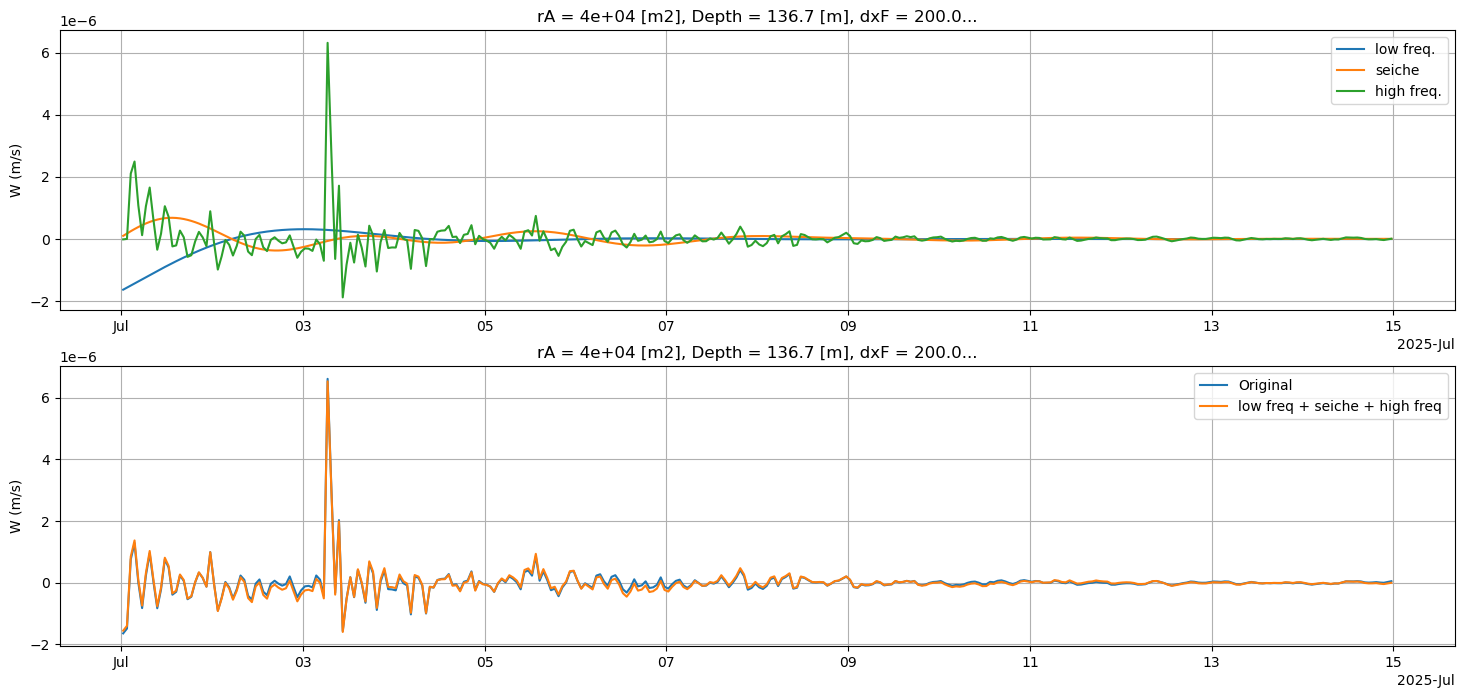

In [69]:
plot_comparison_timeseries(xx, yy, w, wlow, wseiche, whigh, 'W', x_name="XC", y_name="YC")
plt.savefig(os.path.join(path_cutoff_folder, f'plot_filtered_timeseries_{cutoff2_hr}-{cutoff1_hr}h_W.png'))

In [71]:
useiche.to_netcdf(os.path.join(path_cutoff_folder, rf"u_surface_filtered_{cutoff2_hr}-{cutoff1_hr}h.nc"))
vseiche.to_netcdf(os.path.join(path_cutoff_folder, rf"v_surface_filtered_{cutoff2_hr}-{cutoff1_hr}h.nc"))
wseiche.to_netcdf(os.path.join(path_cutoff_folder, rf"w_surface_filtered_{cutoff2_hr}-{cutoff1_hr}h.nc"))

# Energy analysis

In [6]:
cutoff1_hr = 90
cutoff2_hr = 46

cutoff1 = 1/(cutoff1_hr * 3600)
cutoff2 = 1/(cutoff2_hr * 3600)

In [9]:
useiche = xr.open_dataset(os.path.join(path_cutoff_folder, rf"u_surface_filtered_{cutoff2_hr}-{cutoff1_hr}h.nc")).UVEL
vseiche = xr.open_dataset(os.path.join(path_cutoff_folder, rf"v_surface_filtered_{cutoff2_hr}-{cutoff1_hr}h.nc")).VVEL
wseiche = xr.open_dataset(os.path.join(path_cutoff_folder, rf"w_surface_filtered_{cutoff2_hr}-{cutoff1_hr}h.nc")).WVEL

In [50]:
aligned_useiche = useiche.rename({'XG':'XC'})
aligned_useiche['XC'] = wseiche['XC']

aligned_vseiche = vseiche.rename({'YG':'YC'})
aligned_vseiche['YC'] = wseiche['YC']

aligned_wseiche = wseiche.rename({'Zl':'Z'})
aligned_wseiche['Z'] = useiche['Z']

In [51]:
ke_mj_seiche = compute_ke(aligned_useiche, aligned_vseiche, aligned_wseiche, 200, 200, aligned_useiche.drF.values)

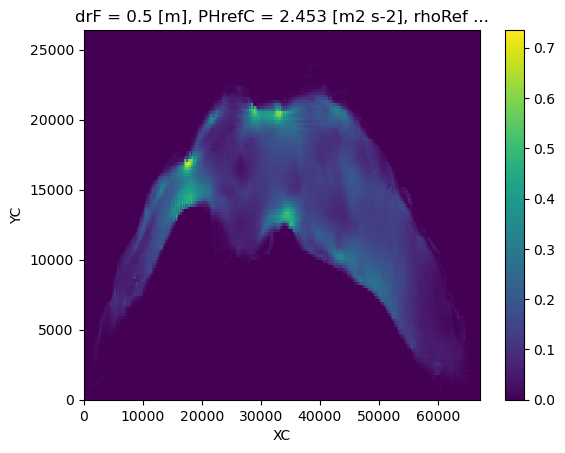

In [52]:
ke_mj_seiche.isel(time=72).plot()

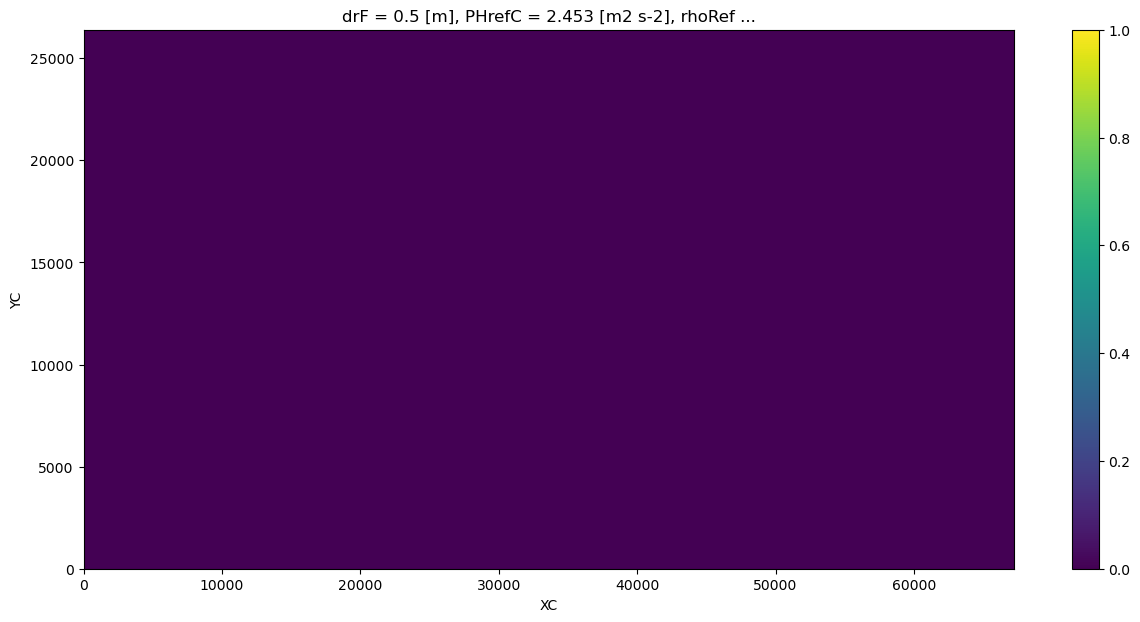

In [63]:
path_map = os.path.join(path_cutoff_folder, r"map_ke_surface")
os.makedirs(path_map, exist_ok=True)
for i in range(ke_mj_seiche.sizes['time']):
    plt.close('all')
    plt.figure(figsize=(15,7))
    ke_mj_seiche.isel(time=i).plot(vmax=1)
    plt.title(ke_mj_seiche.time.isel(time=i).values)
    plt.savefig(os.path.join(path_map, rf"ke_surface_time{i}_{cutoff2_hr}-{cutoff1_hr}h.png"))

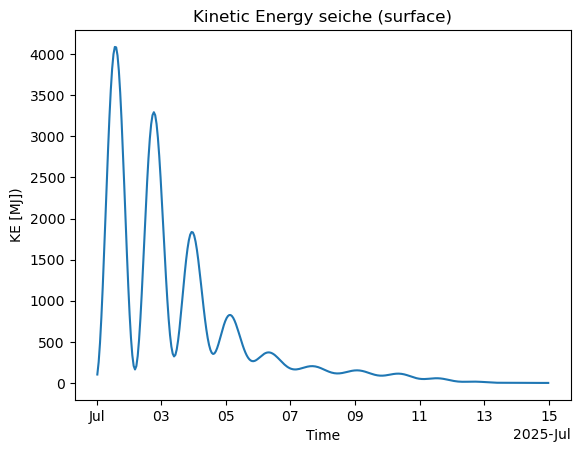

In [72]:
ke_mj_seiche.sum(dim=['XC','YC']).plot()
plt.title('Kinetic Energy seiche (surface)')
plt.ylabel('KE [MJ])')
plt.savefig(os.path.join(path_cutoff_folder, "seiche_surface_ke"))

In [65]:
df_ke = ke_mj_seiche.sum(dim=['XC','YC']).to_dataframe(name='ke_mj_seiche')['ke_mj_seiche'].reset_index()

In [66]:
df_ke.to_csv(os.path.join(path_cutoff_folder, rf"ke_surface_seiche_{cutoff2_hr}-{cutoff1_hr}h.csv"))